In [1]:
%load_ext autoreload
%autoreload 2

In [101]:
import numpy as np
import pylab as plt

import sys
sys.path.append('../')

from seislab.src import tprt
from seislab.src import dsp
from seislab.src import seislet
from seislab.src import plot_seismic

In [106]:
v_1 = tprt.ISOVelocity(2000.0, 1000.)
rho_1 = 2300.0

v_2 = tprt.ISOVelocity(2500.0, 1000.)
rho_2 = 2400.0

v_3 = tprt.ISOVelocity(3500.0, 1000.)
rho_3 = 2400.0

hor_1 = tprt.FlatHorizon(
    depth=200.0, 
    anchor=np.array([0, 0]), 
    dip=0.0, 
    azimuth=0.0, 
    region=np.array([[-1000, -1000], [1000, 1000]])
)

hor_2 = tprt.FlatHorizon(
    depth=500.0, 
    anchor=np.array([0, 0]), 
    dip=0.0, 
    azimuth=0.0, 
    region=np.array([[-1000, -1000], [1000, 1000]])
)

model = tprt.VelocityModel(
    velocity = np.array([v_1, v_2, v_3]),
    density = np.array([rho_1, rho_2, rho_3]),
    name = np.array(['1', '2', '3']),
    horizons = [hor_1, hor_2]
)

In [107]:
def plot_survey(
    survey, 
    ax=None, 
    fig_width=10, 
    fig_height=10,
    source_marker='^',
    receiver_marker='s',
    source_size=15,
    receiver_size=10,
    x_label='X, m',
    y_label='Y, m',
    grid=True,
    xlim=None,
    ylim=None,
):
    if isinstance(ax, type(None)):
        fig, ax = plt.subplots(figsize=(fig_width, fig_height), facecolor='w')
    
    src = np.array([x.location for x in survey.sources.ravel()])
    rec = np.array([x.location for x in survey.receivers.ravel()])
    print(src.shape)
    ax.plot(
        rec[:, 0], 
        rec[:, 1], 
        marker=receiver_marker, 
        markerfacecolor='k', 
        markeredgecolor='k', 
        linestyle='None',
        markersize=receiver_size,
    )
    
    ax.plot(
        src[:, 0], 
        src[:, 1], 
        marker=source_marker, 
        markerfacecolor='r', 
        markeredgecolor='r',
        markersize=source_size,
    )
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    if grid:
        ax.grid()
        
    if not isinstance(xlim, type(None)):
        ax.set_xlim(xlim)
        
    if not isinstance(ylim, type(None)):
        ax.set_ylim(ylim)

In [118]:
source_freq = 25.0
source_location = np.array([0, 0, 0], dtype=float)

source = tprt.DilatCenter(
    vel_model=model,
    location=source_location,
    f=source_freq
)

# Profile

In [119]:
rec_loc_x = np.arange(-800, 800, 100)
receivers_profile = np.empty(rec_loc_x.shape, dtype=tprt.Receiver)

for i, _x in enumerate(rec_loc_x):
    receivers_profile[i] = tprt.Receiver([_x, 0.0, 0.0])

In [120]:
survey_profile = tprt.Survey(source, receivers_profile, model)

(1, 3)


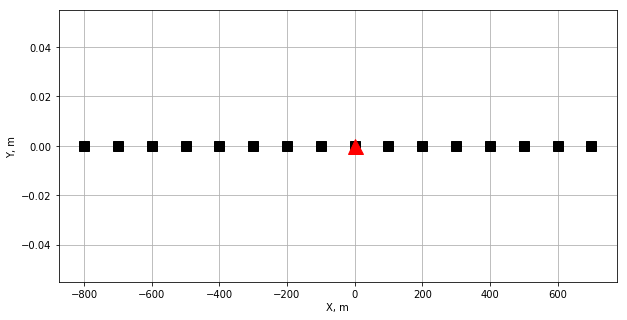

In [121]:
plot_survey(survey_profile, fig_height=5)

In [122]:
travel_times = np.zeros((2, len(receivers_profile)))
amplitudes = np.zeros((2, len(receivers_profile)))
for i in range(2):
    survey_profile.initialize_rays(reflect_horizon=i+1, vtype='vp', forward=False)
    survey_profile.calculate(method='bfgs', survey2D=False)
    travel_times[i] = survey_profile.traveltimes[0]
    amplitudes[i] = np.abs(survey_profile.amplitudes[0,:,0])

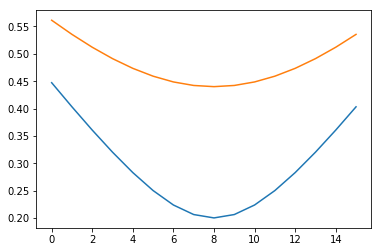

In [123]:
plt.plot(travel_times.T)

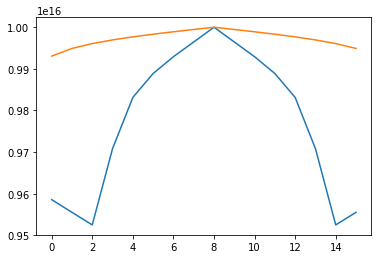

In [127]:
amplitudes = 1 / (amplitudes + 1e-16) 
plt.plot(amplitudes.T)

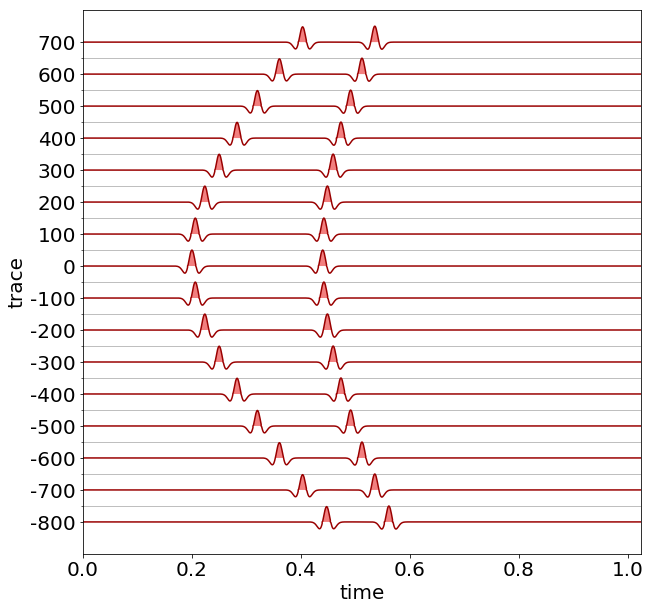

In [130]:
traces_r1 = seislet.seismic_signal(tau=travel_times[0][...,None], f=30, dt=0.001, ns=1024)
traces_r2 = seislet.seismic_signal(tau=travel_times[1][...,None], f=30, dt=0.001, ns=1024)
traces_profile = amplitudes[0][...,None] * traces_r1 + amplitudes[1][...,None]*traces_r2
plot_seismic.plot_traces(
    traces_profile, 
    dt=0.001, 
    offset=rec_loc_x, 
    fill_positive=True,
    
)

# Surface

In [51]:
# Поверхностная сеть наблюдения
rec_loc_x = np.arange(-800, 800, 100)
X, Y = np.meshgrid(rec_loc_x, rec_loc_x)
receivers_surface = np.empty(X.shape, dtype=tprt.Receiver)
for i, _x in np.ndenumerate(X):
    receivers_surface[i] = tprt.Receiver([_x, Y[i], 0.0])

In [55]:
survey_surface = tprt.Survey(source, receivers_surface, model)

(1, 3)


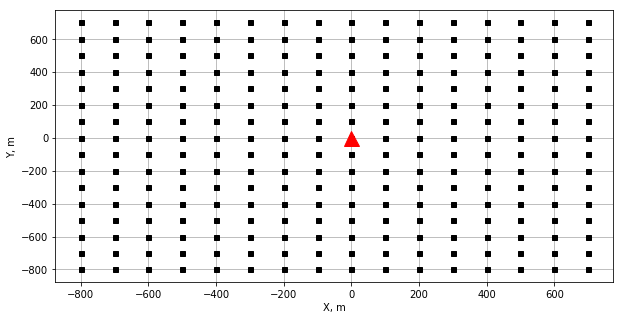

In [65]:
plot_survey(survey_surface, fig_height=5, receiver_size=5)